# Diffusion Posterior Sampling (DPS) for General Noisy Inverse Problems

This notebook implements DPS for solving inverse problems using diffusion models.

**Paper:** Diffusion Posterior Sampling for General Noisy Inverse Problems (ICLR 2023)


## 1. Check GPU and Install Dependencies


In [1]:
# Check GPU availability
!nvidia-smi


Wed Nov 19 18:30:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required packages
%pip install -q torch torchvision matplotlib pyyaml tqdm pillow scipy


In [3]:
# Clone the DPS repository
!git clone https://github.com/DPS2022/diffusion-posterior-sampling.git
%cd diffusion-posterior-sampling


Cloning into 'diffusion-posterior-sampling'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 82 (delta 29), reused 29 (delta 29), pack-reused 23 (from 1)
Receiving objects: 100% (82/82), 16.19 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/diffusion-posterior-sampling


In [4]:
# Clone external dependencies
!git clone https://github.com/VinAIResearch/blur-kernel-space-exploring bkse
!git clone https://github.com/LeviBorodenko/motionblur motionblur

Cloning into 'bkse'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (577/577), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 577 (delta 334), reused 461 (delta 232), pack-reused 0 (from 0)
Receiving objects: 100% (577/577), 1.05 MiB | 35.68 MiB/s, done.
Resolving deltas: 100% (334/334), done.
Cloning into 'motionblur'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36 (from 1)
Receiving objects: 100% (36/36), 511.08 KiB | 26.90 MiB/s, done.
Resolving deltas: 100% (12/12), done.


## 2. Download Pretrained Model


In [5]:
# If you have your own checkpoint, upload it here
# Uncomment to upload:
# from google.colab import files
# uploaded = files.upload()
# !mv ffhq_10m.pt models/


## 3. Import Required Libraries


In [6]:
import os
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from functools import partial
import torchvision.transforms as transforms
from tqdm import tqdm

# Import DPS modules
from guided_diffusion.condition_methods import get_conditioning_method
from guided_diffusion.measurements import get_noise, get_operator
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler
from util.img_utils import clear_color

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✓ All imports successful!
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 4. Configuration


In [7]:
# Model configuration
model_config = {
    'image_size': 256,
    'num_channels': 128,
    'num_res_blocks': 1,
    'channel_mult': '',
    'learn_sigma': True,
    'class_cond': False,
    'use_checkpoint': False,
    'attention_resolutions': 16,
    'num_heads': 4,
    'num_head_channels': 64,
    'num_heads_upsample': -1,
    'use_scale_shift_norm': True,
    'dropout': 0.0,
    'resblock_updown': True,
    'use_fp16': False,
    'use_new_attention_order': False,
    'model_path': '/content/drive/MyDrive/ffhq_10m.pt'
}

# Diffusion configuration
diffusion_config = {
    'sampler': 'ddpm',
    'steps': 1000,  # Number of diffusion steps
    'noise_schedule': 'linear',
    'model_mean_type': 'epsilon',
    'model_var_type': 'learned_range',
    'dynamic_threshold': False,
    'clip_denoised': True,
    'rescale_timesteps': False,
    'timestep_respacing': '1000'  # Can reduce for faster inference (e.g., '250')
}

# # Task configuration - Super Resolution 4x
# task_config = {
#     'conditioning': {
#         'method': 'ps',
#         'params': {'scale': 1.0}
#     },
#     'measurement': {
#         'operator': {
#             'name': 'super_resolution',
#             'in_shape': [1, 3, 256, 256],
#             'scale_factor': 4
#         },
#         'noise': {
#             'name': 'gaussian',
#             'sigma': 0.05
#         }
#     }
# }

# task_config = {
#     'conditioning': {'method': 'ps', 'params': {'scale': 0.3}},
#     'measurement': {
#         'operator': {
#             'name': 'motion_blur',
#             'kernel_size': 61,
#             'intensity': 0.5  # Motion blur intensity (0.1 to 1.0, higher = more blur)
#         },
#         'noise': {'name': 'gaussian', 'sigma': 0.05}
#     }
# }

# task_config = {
#     'conditioning': {'method': 'ps', 'params': {'scale': 0.3}},
#     'measurement': {
#         'operator': {
#             'name': 'gaussian_blur',
#             'kernel_size': 61,
#             'intensity': 3.0
#         },
#         'noise': {'name': 'gaussian', 'sigma': 0.05}
#     }
# }

# print("✓ Configuration loaded!")
# print(f"  Task: {task_config['measurement']['operator']['name']}")
# print(f"  Noise: {task_config['measurement']['noise']['name']}")
# print(f"  Diffusion steps: {diffusion_config['steps']}")
task_config = {
    'conditioning': {'method': 'ps', 'params': {'scale': 0.5}},
    'measurement': {
        'operator': {'name': 'inpainting'},
        'noise': {'name': 'gaussian', 'sigma': 0.0},
        'mask_opt': {
            'mask_type': 'box',
            'mask_len_range': (96, 97),  # 96×96 mask
            'image_size': 256,
            'margin': 32  # Can use int (converts to tuple)
        }
    }
}


## 5. Load Model and Setup DPS


In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
print("Loading diffusion model...")
model = create_model(**model_config)
model = model.to(device)
model.eval()
print("✓ Model loaded!")

# Prepare operator and noise
measure_config = task_config['measurement']
operator = get_operator(device=device, **measure_config['operator'])
noiser = get_noise(**measure_config['noise'])
print(f"✓ Operator: {measure_config['operator']['name']}")
print(f"✓ Noise: {measure_config['noise']['name']}")

# Prepare conditioning method
cond_config = task_config['conditioning']
cond_method = get_conditioning_method(
    cond_config['method'],
    operator,
    noiser,
    **cond_config['params']
)
measurement_cond_fn = cond_method.conditioning
print(f"✓ Conditioning method: {cond_config['method']}")

# Load diffusion sampler
print("Creating sampler...")
sampler = create_sampler(**diffusion_config)
sample_fn = partial(
    sampler.p_sample_loop,
    model=model,
    measurement_cond_fn=measurement_cond_fn
)
print("✓ Setup complete!")


Using device: cuda
Loading diffusion model...
✓ Model loaded!
✓ Operator: inpainting
✓ Noise: gaussian
✓ Conditioning method: ps
Creating sampler...
✓ Setup complete!


## 6. Load and Prepare Test Image


Loading images from zip file...
Zip file: /content/drive/MyDrive/CelebA-HQ resized (256x256).zip
✓ Extracted zip file to: /tmp/extracted_dataset
✓ Found 30000 images in total
✓ Selected 5 images for inference:
  1. 19857.jpg
  2. 26678.jpg
  3. 13734.jpg
  4. 23566.jpg
  5. 01342.jpg

✓ All images loaded successfully!
  Shape: torch.Size([1, 3, 256, 256])


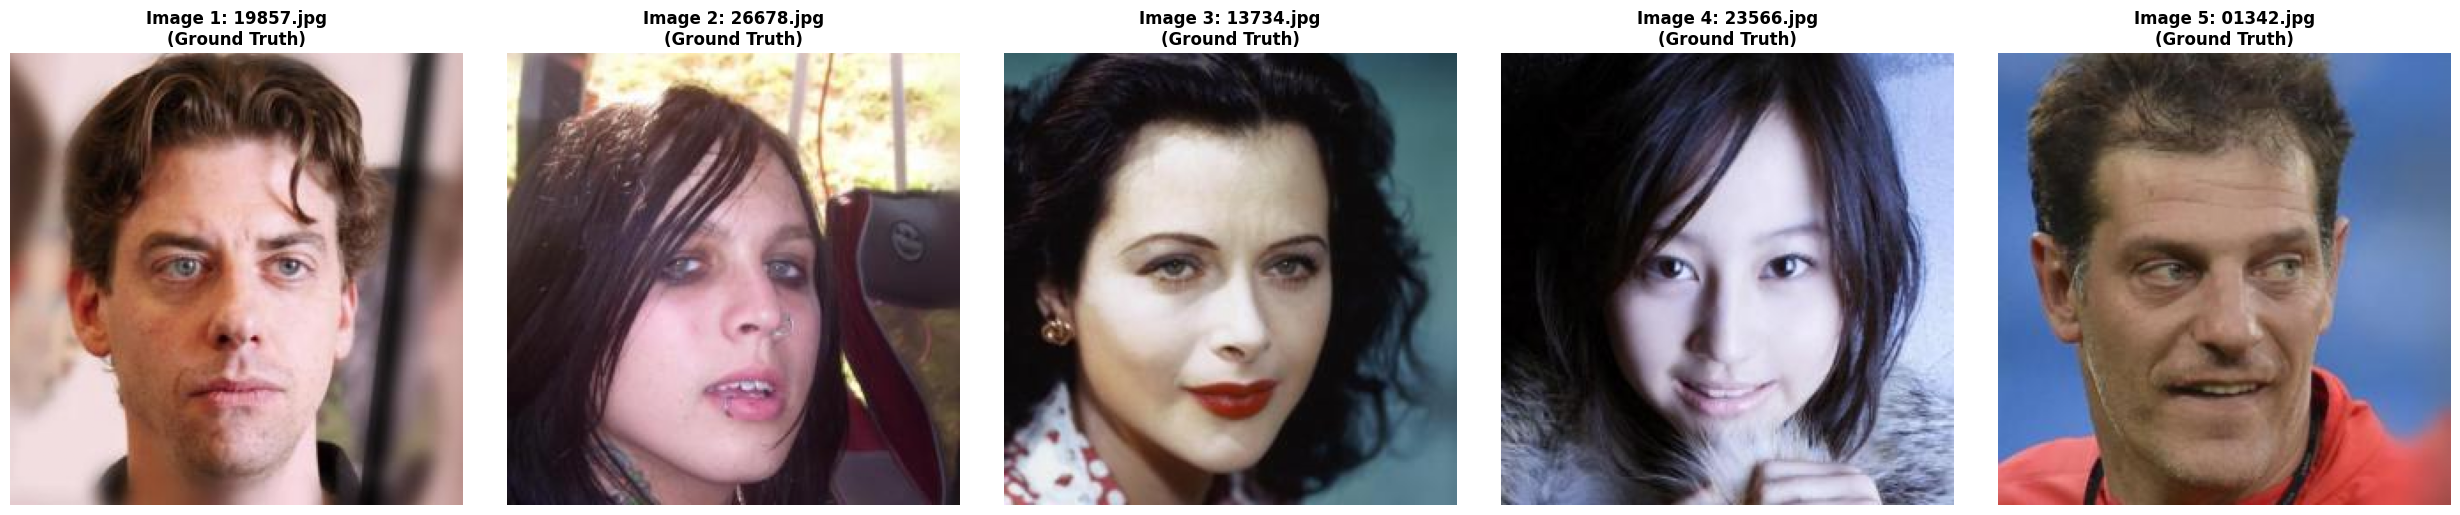


READY FOR INFERENCE
Loaded 5 images. You can access them via test_images list.
Example: test_images[0]['tensor'] for the first image


In [9]:
import zipfile
import random
from pathlib import Path

# ====================================================================================
# CONFIGURATION: Set your Google Drive zip file path here
# ====================================================================================
zip_file_path = '/content/drive/MyDrive/CelebA-HQ resized (256x256).zip'  # Change this to your zip file path
num_images_to_load = 5  # Number of images to use for inference
# ====================================================================================

print("Loading images from zip file...")
print(f"Zip file: {zip_file_path}")

# Extract zip file
extract_dir = '/tmp/extracted_dataset'
os.makedirs(extract_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✓ Extracted zip file to: {extract_dir}")
except FileNotFoundError:
    raise FileNotFoundError(f"Zip file not found at: {zip_file_path}\nPlease check the path and ensure Google Drive is mounted.")
except Exception as e:
    raise Exception(f"Error extracting zip file: {e}")

# Find all image files in the extracted directory
image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
image_files = []
for ext in image_extensions:
    image_files.extend(Path(extract_dir).rglob(f'*{ext}'))
    image_files.extend(Path(extract_dir).rglob(f'*{ext.upper()}'))

if len(image_files) == 0:
    raise ValueError(f"No images found in the zip file. Looking for extensions: {image_extensions}")

print(f"✓ Found {len(image_files)} images in total")

# Select random images (or first N images)
if len(image_files) < num_images_to_load:
    print(f"⚠ Warning: Only {len(image_files)} images available, using all of them")
    selected_images = image_files
else:
    # Use random selection for variety
    selected_images = random.sample(image_files, num_images_to_load)
    # Or use first N images: selected_images = image_files[:num_images_to_load]

print(f"✓ Selected {len(selected_images)} images for inference:")
for i, img_path in enumerate(selected_images, 1):
    print(f"  {i}. {img_path.name}")

# Transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load and store all selected images
test_images = []
for img_path in selected_images:
    img = Image.open(img_path).convert('RGB')
    ref_img = transform(img).unsqueeze(0).to(device)
    test_images.append({
        'tensor': ref_img,
        'path': str(img_path),
        'name': img_path.name
    })

print(f"\n✓ All images loaded successfully!")
print(f"  Shape: {test_images[0]['tensor'].shape}")

# Display all selected images
fig, axes = plt.subplots(1, len(test_images), figsize=(5*len(test_images), 5))
if len(test_images) == 1:
    axes = [axes]  # Make it iterable

for idx, (ax, img_data) in enumerate(zip(axes, test_images)):
    ax.imshow(clear_color(img_data['tensor']))
    ax.set_title(f"Image {idx+1}: {img_data['name']}\n(Ground Truth)", fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("READY FOR INFERENCE")
print("="*70)
print(f"Loaded {len(test_images)} images. You can access them via test_images list.")
print("Example: test_images[0]['tensor'] for the first image")
print("="*70)


## 7. Create Degraded Measurement


Creating degraded measurements for all images...

Processing image 1/5: 19857.jpg
  Mask type: box
  Mask parameters: {'mask_type': 'box', 'image_size': 256, 'mask_len_range': (96, 97), 'margin': (32, 32)}
  ✓ Mask generated! Shape: torch.Size([1, 1, 256, 256])
  ✓ Measurement created! Original: torch.Size([1, 3, 256, 256]), Degraded: torch.Size([1, 3, 256, 256])

Processing image 2/5: 26678.jpg
  Mask type: box
  Mask parameters: {'mask_type': 'box', 'image_size': 256, 'mask_len_range': (96, 97), 'margin': (32, 32)}
  ✓ Mask generated! Shape: torch.Size([1, 1, 256, 256])
  ✓ Measurement created! Original: torch.Size([1, 3, 256, 256]), Degraded: torch.Size([1, 3, 256, 256])

Processing image 3/5: 13734.jpg
  Mask type: box
  Mask parameters: {'mask_type': 'box', 'image_size': 256, 'mask_len_range': (96, 97), 'margin': (32, 32)}
  ✓ Mask generated! Shape: torch.Size([1, 1, 256, 256])
  ✓ Measurement created! Original: torch.Size([1, 3, 256, 256]), Degraded: torch.Size([1, 3, 256, 256])


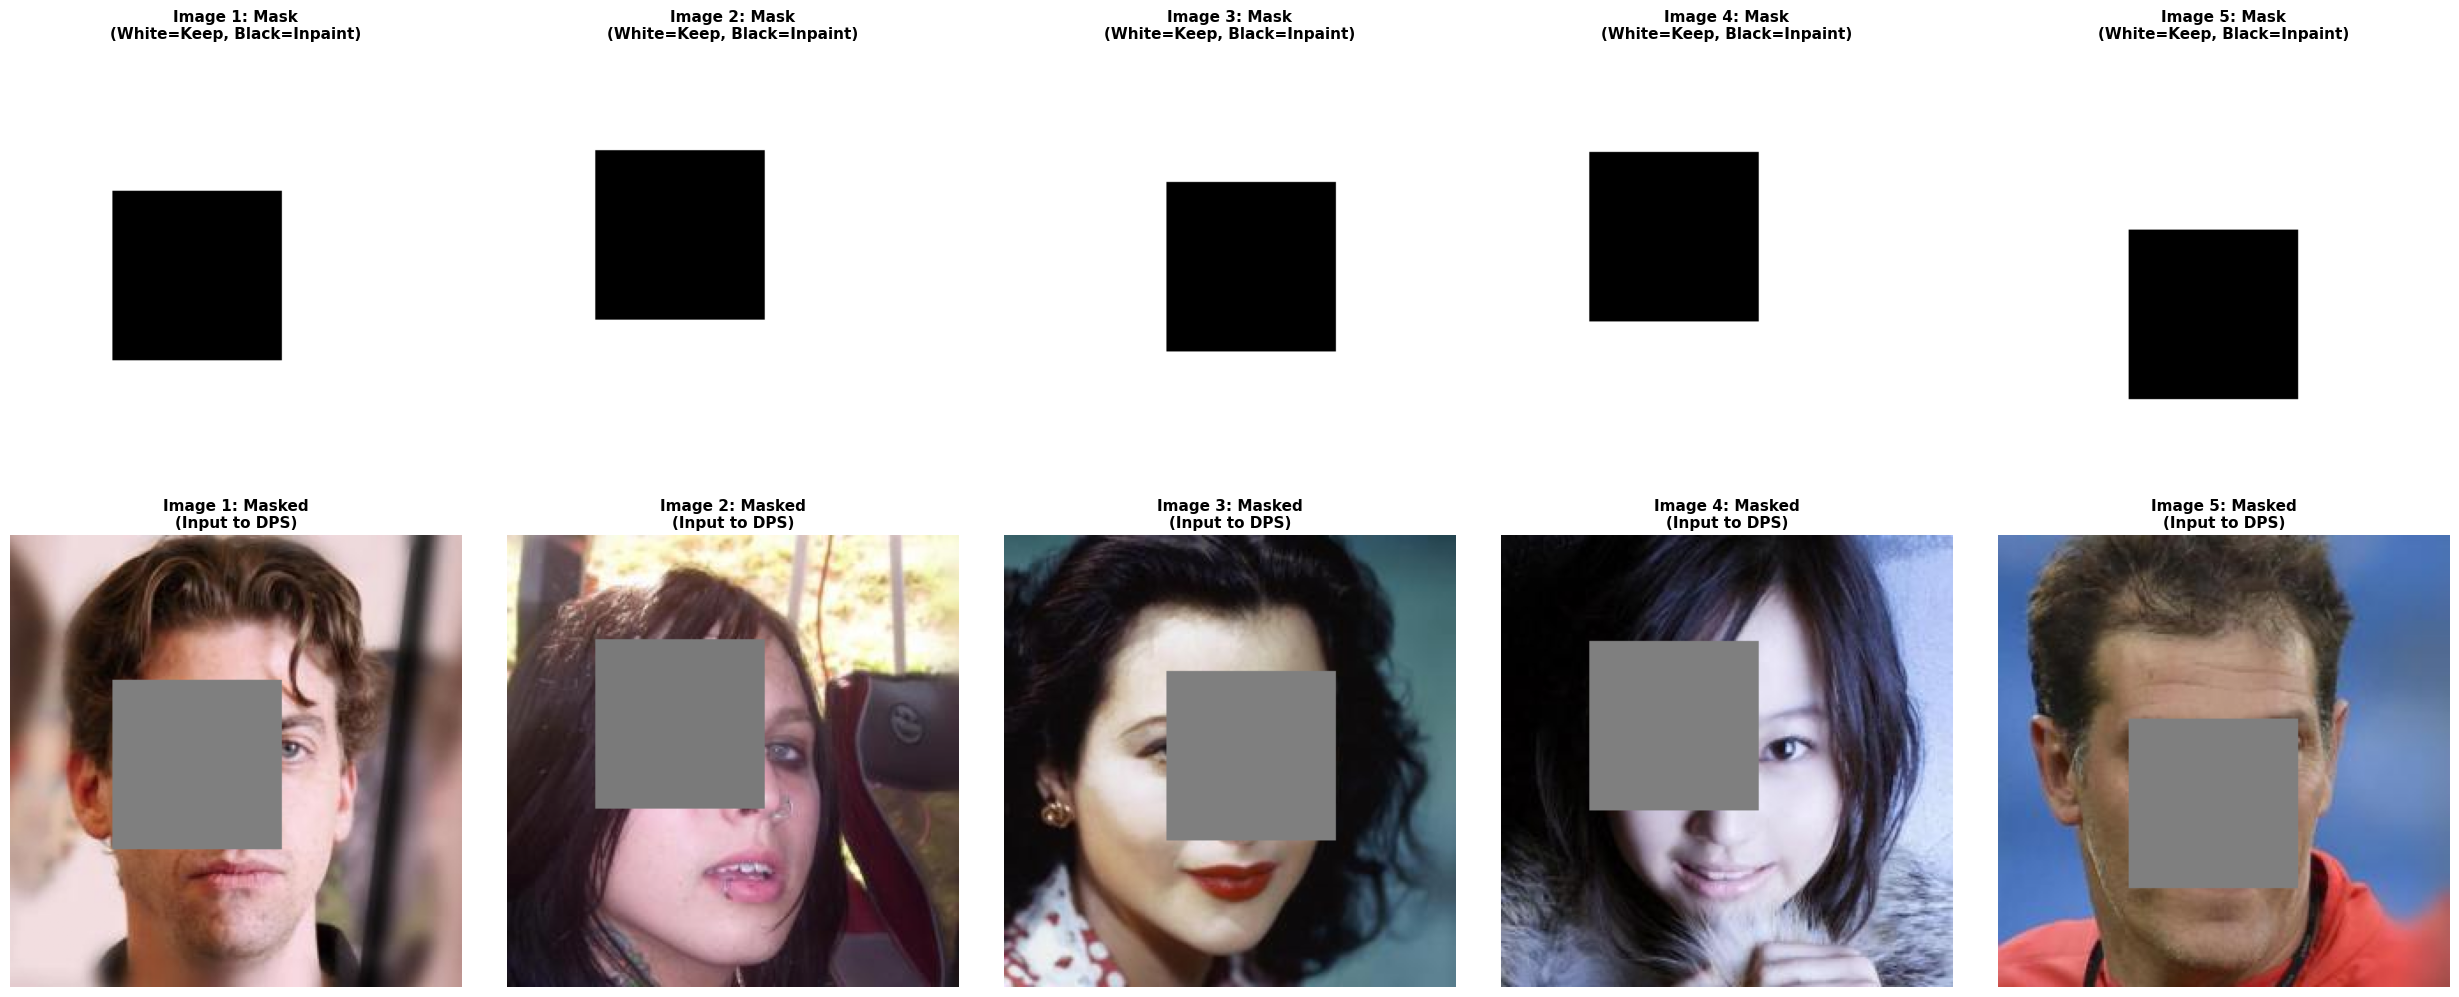

In [10]:
# Create degraded measurements for all test images
print("Creating degraded measurements for all images...")

measure_config = task_config['measurement']

# Store degraded measurements for all images
measurements = []

for idx, img_data in enumerate(test_images):
    print(f"\nProcessing image {idx+1}/{len(test_images)}: {img_data['name']}")
    ref_img = img_data['tensor']

    # Special handling for inpainting: generate mask
    if measure_config['operator']['name'] == 'inpainting':
        from util.img_utils import mask_generator

        # Prepare mask generator parameters
        mask_opt = measure_config.get('mask_opt', {})

        # Set default parameters based on mask_type if not provided
        mask_type = mask_opt.get('mask_type', 'box')
        image_size = mask_opt.get('image_size', 256)

        # Build parameters dict
        mask_params = {
            'mask_type': mask_type,
            'image_size': image_size
        }

        # For 'box' type: need mask_len_range
        if mask_type == 'box':
            # mask_len_range: (min_size, max_size) for the box
            mask_params['mask_len_range'] = mask_opt.get('mask_len_range', (128, 129))

            # Handle margin - convert to tuple if needed
            margin = mask_opt.get('margin', (16, 16))
            if isinstance(margin, int):
                margin = (margin, margin)  # Convert single int to tuple
            mask_params['margin'] = margin

        # For 'random' type: need mask_prob_range
        elif mask_type == 'random':
            # mask_prob_range: (min_prob, max_prob) of pixels to mask
            mask_params['mask_prob_range'] = mask_opt.get('mask_prob_range', (0.3, 0.7))

        print(f"  Mask type: {mask_type}")
        print(f"  Mask parameters: {mask_params}")

        # Generate mask
        mask_gen = mask_generator(**mask_params)
        mask = mask_gen(ref_img)
        mask = mask[:, 0, :, :].unsqueeze(dim=0)

        print(f"  ✓ Mask generated! Shape: {mask.shape}")

        # Forward with mask
        y = operator.forward(ref_img, mask=mask)
        y_n = noiser(y)

        # Store measurement with mask
        measurements.append({
            'original': ref_img,
            'degraded': y_n,
            'mask': mask,
            'name': img_data['name']
        })

    else:
        # For other tasks (super-resolution, deblurring, etc.)
        y = operator.forward(ref_img)
        y_n = noiser(y)

        # Store measurement without mask
        measurements.append({
            'original': ref_img,
            'degraded': y_n,
            'mask': None,
            'name': img_data['name']
        })

    print(f"  ✓ Measurement created! Original: {ref_img.shape}, Degraded: {y_n.shape}")

print(f"\n{'='*70}")
print(f"✓ All {len(measurements)} measurements created successfully!")
print(f"{'='*70}")

# Display all degraded images
if measure_config['operator']['name'] == 'inpainting':
    # For inpainting, show masks and masked images
    fig, axes = plt.subplots(2, len(measurements), figsize=(5*len(measurements), 10))
    if len(measurements) == 1:
        axes = axes.reshape(2, 1)

    for idx, meas in enumerate(measurements):
        # Show mask
        axes[0, idx].imshow(meas['mask'][0, 0].cpu().numpy(), cmap='gray')
        axes[0, idx].set_title(f"Image {idx+1}: Mask\n(White=Keep, Black=Inpaint)", fontsize=11, fontweight='bold')
        axes[0, idx].axis('off')

        # Show masked image
        axes[1, idx].imshow(clear_color(meas['degraded']))
        axes[1, idx].set_title(f"Image {idx+1}: Masked\n(Input to DPS)", fontsize=11, fontweight='bold')
        axes[1, idx].axis('off')
else:
    # For other tasks, just show degraded images
    fig, axes = plt.subplots(1, len(measurements), figsize=(5*len(measurements), 5))
    if len(measurements) == 1:
        axes = [axes]

    for idx, (ax, meas) in enumerate(zip(axes, measurements)):
        ax.imshow(clear_color(meas['degraded']))
        ax.set_title(f"Image {idx+1}: Degraded\n(Input to DPS)", fontsize=12, fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()


## 8. Run DPS Inference 🚀

**This is the main step!** The diffusion model will iteratively reconstruct the image from the degraded measurement.

**Important:** Unlike standard diffusion sampling, DPS requires **gradients enabled** to compute the posterior sampling guidance. This is why we don't use `torch.no_grad()` here.

On GPU (T4/V100), this takes approximately **5-10 minutes** for 1000 steps.


In [11]:
import time

print("="*70)
print("Starting DPS Inference for All Images...")
print(f"Total images: {len(measurements)}")
print(f"Diffusion steps: {diffusion_config['steps']}")
print(f"Device: {device}")
print("="*70)

# Store all reconstructed images
reconstructed_images = []

# Process each image
for idx, meas in enumerate(measurements):
    print(f"\n{'='*70}")
    print(f"Processing Image {idx+1}/{len(measurements)}: {meas['name']}")
    print(f"{'='*70}")

    ref_img = meas['original']
    y_n = meas['degraded']

    # Initialize with random noise
    # Note: DPS requires gradients for computing posterior sampling guidance
    x_start = torch.randn(ref_img.shape, device=device).requires_grad_()

    # For inpainting, update the conditioning function to include mask
    if task_config['measurement']['operator']['name'] == 'inpainting':
        mask = meas['mask']
        measurement_cond_fn_with_mask = partial(cond_method.conditioning, mask=mask)
        sample_fn_current = partial(
            sampler.p_sample_loop,
            model=model,
            measurement_cond_fn=measurement_cond_fn_with_mask
        )
        print("✓ Inpainting mode: mask passed to conditioning function")
    else:
        sample_fn_current = sample_fn

    # Run sampling with timing
    start_time = time.time()

    # DPS needs gradients enabled (unlike standard diffusion sampling)
    reconstructed = sample_fn_current(
        x_start=x_start,
        measurement=y_n,
        record=False,
        save_root=None
    )

    end_time = time.time()
    elapsed = end_time - start_time

    # Store result
    reconstructed_images.append({
        'reconstructed': reconstructed,
        'original': ref_img,
        'degraded': y_n,
        'name': meas['name'],
        'time': elapsed
    })

    print(f"✓ Inference complete for image {idx+1}!")
    print(f"  Time elapsed: {elapsed/60:.2f} minutes ({elapsed:.1f} seconds)")
    print(f"  Average time per step: {elapsed/diffusion_config['steps']:.3f}s")

# Summary
print(f"\n{'='*70}")
print(f"✓ ALL INFERENCE COMPLETE!")
print(f"{'='*70}")
total_time = sum(img['time'] for img in reconstructed_images)
print(f"Total processing time: {total_time/60:.2f} minutes ({total_time:.1f} seconds)")
print(f"Average time per image: {total_time/len(reconstructed_images)/60:.2f} minutes")
print(f"{'='*70}")


Starting DPS Inference for All Images...
Total images: 5
Diffusion steps: 1000
Device: cuda

Processing Image 1/5: 19857.jpg
✓ Inpainting mode: mask passed to conditioning function


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Inference complete for image 1!
  Time elapsed: 3.32 minutes (199.4 seconds)
  Average time per step: 0.199s

Processing Image 2/5: 26678.jpg
✓ Inpainting mode: mask passed to conditioning function


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Inference complete for image 2!
  Time elapsed: 3.38 minutes (203.0 seconds)
  Average time per step: 0.203s

Processing Image 3/5: 13734.jpg
✓ Inpainting mode: mask passed to conditioning function


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Inference complete for image 3!
  Time elapsed: 3.37 minutes (202.3 seconds)
  Average time per step: 0.202s

Processing Image 4/5: 23566.jpg
✓ Inpainting mode: mask passed to conditioning function


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Inference complete for image 4!
  Time elapsed: 3.38 minutes (203.0 seconds)
  Average time per step: 0.203s

Processing Image 5/5: 01342.jpg
✓ Inpainting mode: mask passed to conditioning function


  0%|          | 0/1000 [00:00<?, ?it/s]

✓ Inference complete for image 5!
  Time elapsed: 3.39 minutes (203.2 seconds)
  Average time per step: 0.203s

✓ ALL INFERENCE COMPLETE!
Total processing time: 16.85 minutes (1010.8 seconds)
Average time per image: 3.37 minutes


## 9. Visualize Results 📊


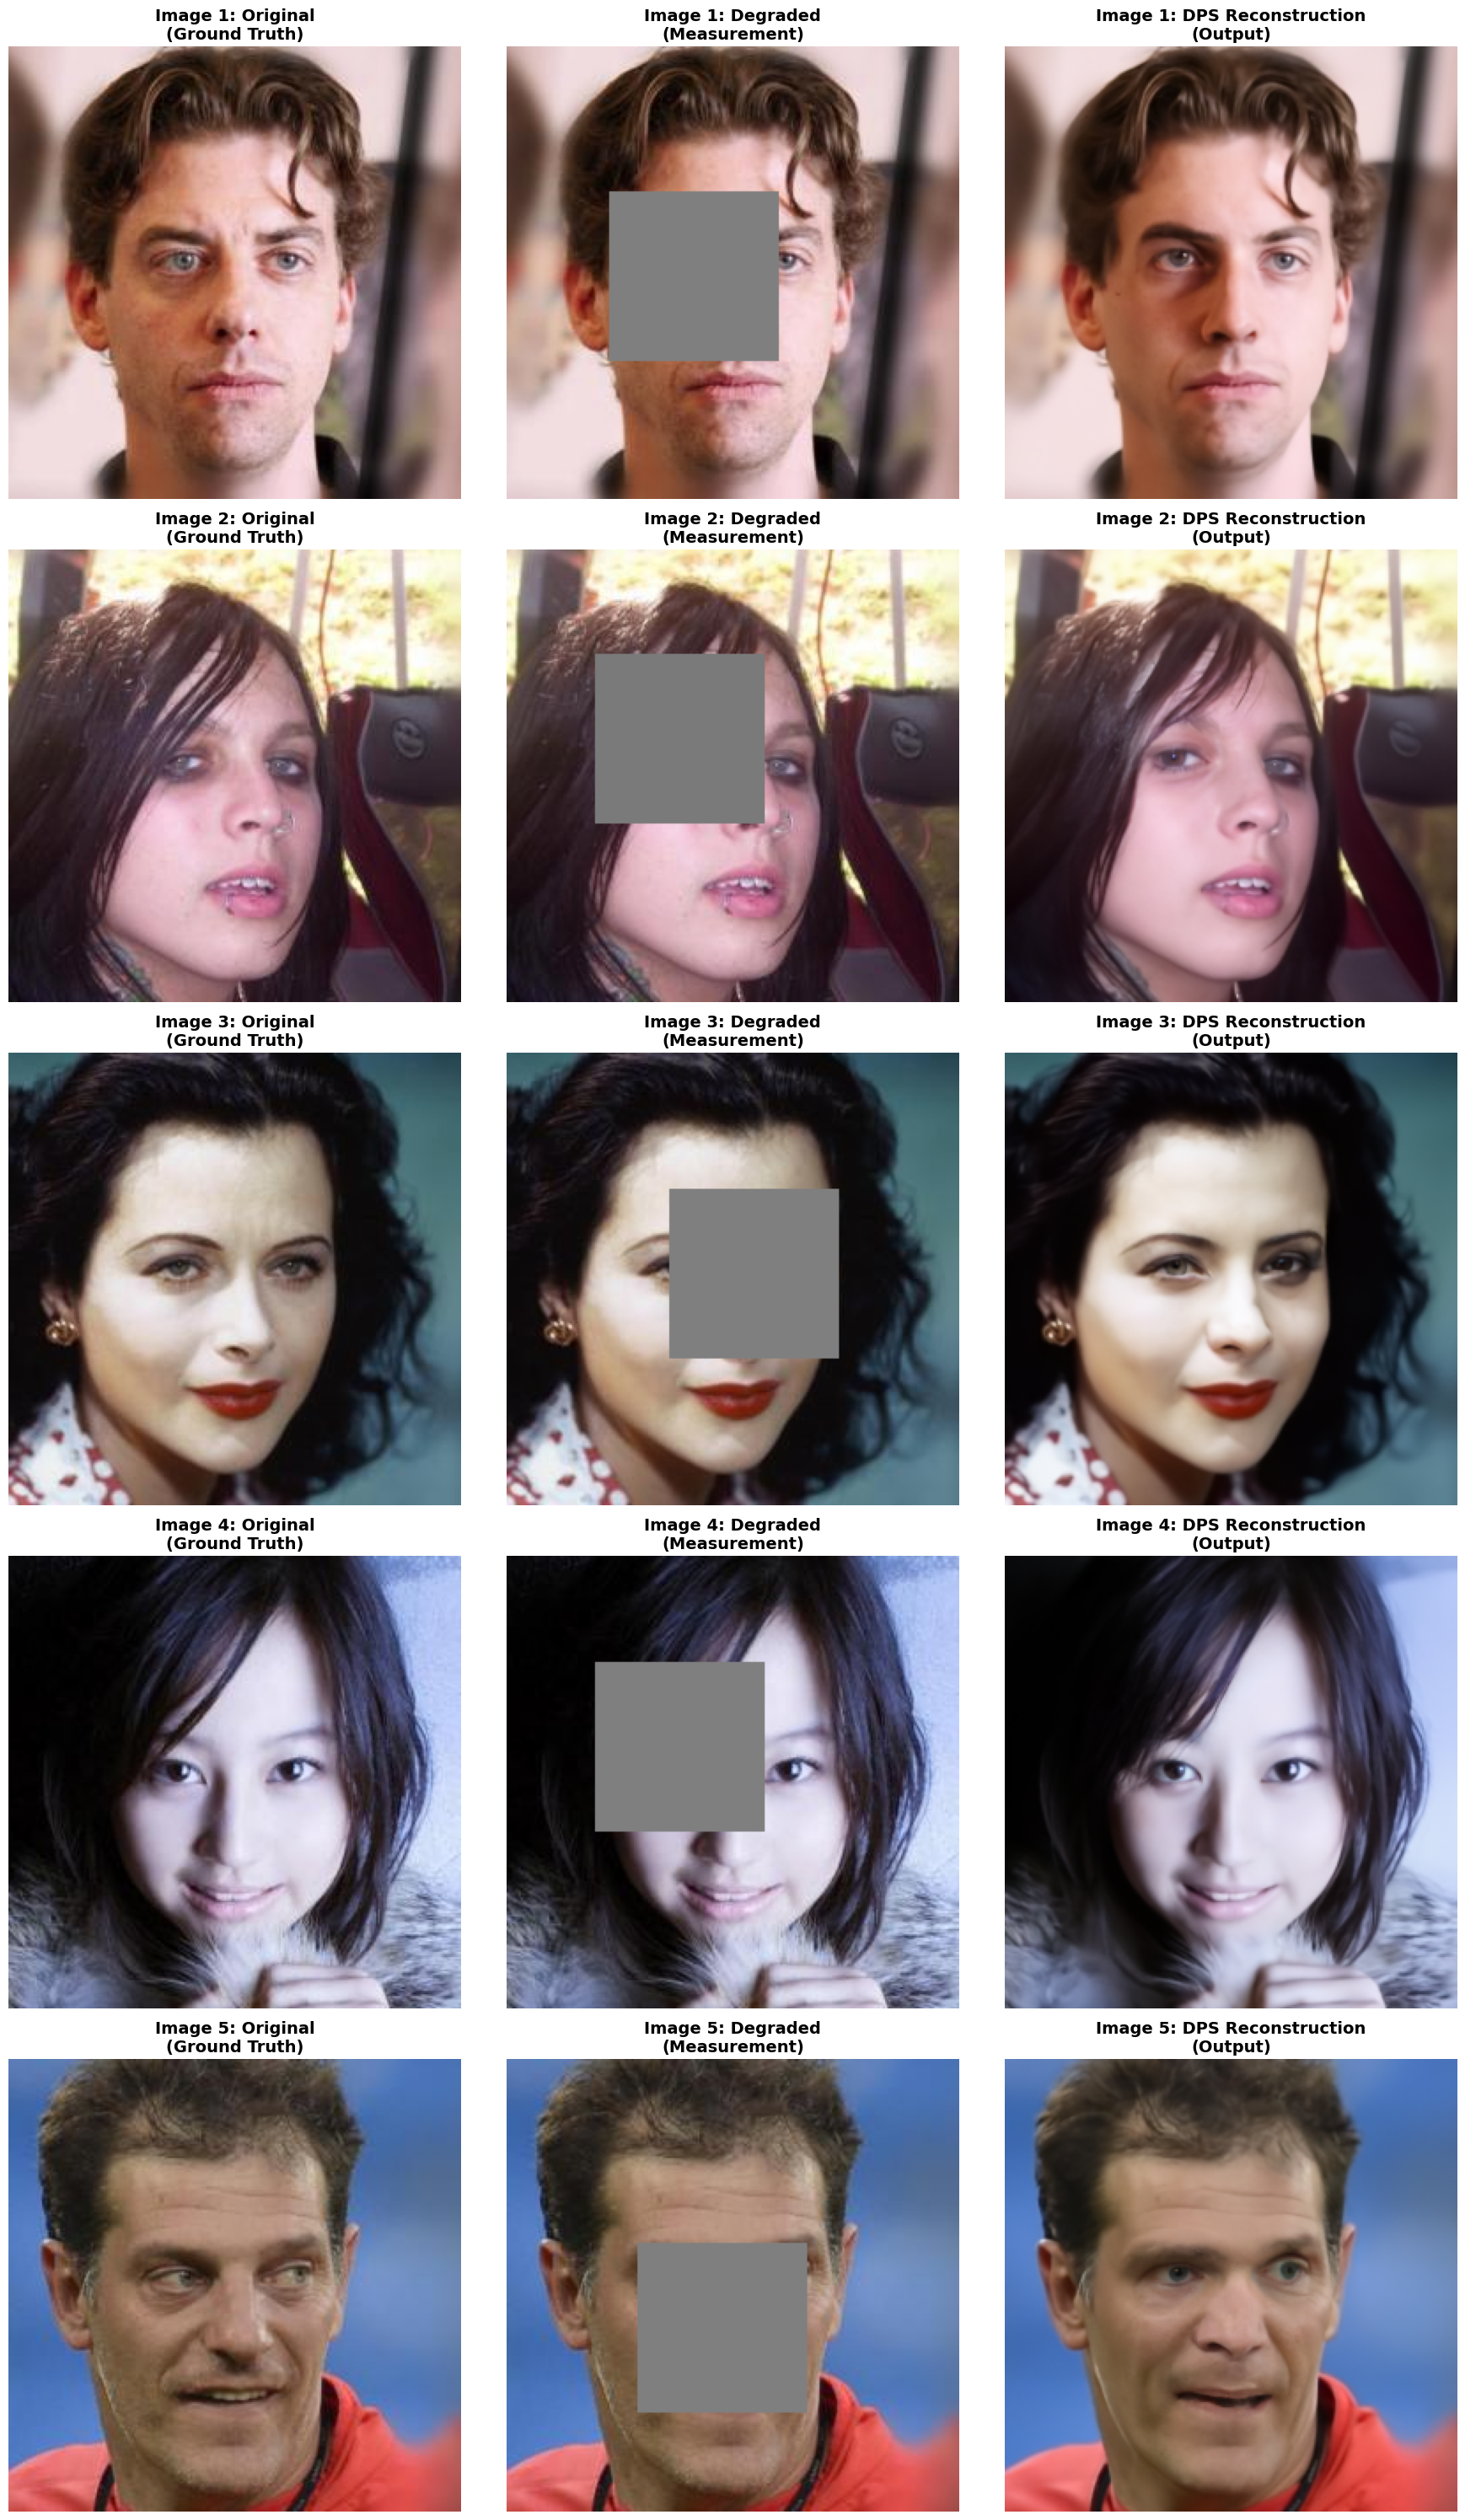

✓ Results saved to 'dps_all_results.png'
  Showing 5 reconstructed images


In [12]:
# Display results for all images
num_images = len(reconstructed_images)
fig, axes = plt.subplots(num_images, 3, figsize=(18, 6*num_images))

# Handle single image case
if num_images == 1:
    axes = axes.reshape(1, -1)

for idx, result in enumerate(reconstructed_images):
    # Original
    axes[idx, 0].imshow(clear_color(result['original']))
    axes[idx, 0].set_title(f"Image {idx+1}: Original\n(Ground Truth)", fontsize=14, fontweight='bold')
    axes[idx, 0].axis('off')

    # Degraded
    axes[idx, 1].imshow(clear_color(result['degraded']))
    axes[idx, 1].set_title(f"Image {idx+1}: Degraded\n(Measurement)", fontsize=14, fontweight='bold')
    axes[idx, 1].axis('off')

    # Reconstructed
    axes[idx, 2].imshow(clear_color(result['reconstructed']))
    axes[idx, 2].set_title(f"Image {idx+1}: DPS Reconstruction\n(Output)", fontsize=14, fontweight='bold')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.savefig('dps_all_results.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"✓ Results saved to 'dps_all_results.png'")
print(f"  Showing {num_images} reconstructed images")


## 10. Calculate Quality Metrics 📈


In [13]:
from torch.nn.functional import mse_loss
import torch.nn.functional as F

def calculate_psnr(img1, img2, max_val=1.0):
    """Calculate PSNR between two images (must be same size)"""
    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes must match: {img1.shape} vs {img2.shape}")
    mse = mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(torch.tensor(max_val) / torch.sqrt(mse))
    return psnr.item()

# Calculate metrics for all images
all_metrics = []

for idx, result in enumerate(reconstructed_images):
    ref_img = result['original']
    reconstructed = result['reconstructed']
    degraded = result['degraded']

    # Normalize to [0, 1] for metrics
    ref_normalized = (ref_img + 1) / 2
    recon_normalized = (reconstructed + 1) / 2
    degraded_normalized = (degraded + 1) / 2

    # Calculate PSNR between reconstructed and original
    psnr_reconstructed = calculate_psnr(ref_normalized, recon_normalized)

    # For super-resolution, we can compute input PSNR by upsampling the degraded image
    if degraded_normalized.shape != ref_normalized.shape:
        # Upsample degraded measurement for comparison (bicubic interpolation)
        degraded_upsampled = F.interpolate(
            degraded_normalized,
            size=ref_normalized.shape[-2:],
            mode='bicubic',
            align_corners=False
        )
        psnr_input = calculate_psnr(ref_normalized, degraded_upsampled)
    else:
        # For tasks like deblurring where sizes match
        psnr_input = calculate_psnr(ref_normalized, degraded_normalized)

    improvement = psnr_reconstructed - psnr_input

    all_metrics.append({
        'name': result['name'],
        'psnr_input': psnr_input,
        'psnr_output': psnr_reconstructed,
        'improvement': improvement
    })

# Display results
print("="*70)
print("QUANTITATIVE RESULTS FOR ALL IMAGES:")
print("="*70)

for idx, metrics in enumerate(all_metrics, 1):
    print(f"\n📷 Image {idx}: {metrics['name']}")
    print(f"{'─'*70}")
    print(f"  Input PSNR:     {metrics['psnr_input']:.2f} dB")
    print(f"  Output PSNR:    {metrics['psnr_output']:.2f} dB")
    print(f"  Improvement:    {metrics['improvement']:+.2f} dB", end="")

    if metrics['improvement'] > 5:
        print(f"  ← EXCELLENT! 🎉")
    elif metrics['improvement'] > 2:
        print(f"  ← GOOD! ✓")
    elif metrics['improvement'] > 0:
        print(f"  ← Modest")
    else:
        print(f"  ← Needs improvement")

# Summary statistics
print(f"\n{'='*70}")
print("SUMMARY STATISTICS:")
print(f"{'='*70}")
avg_input = sum(m['psnr_input'] for m in all_metrics) / len(all_metrics)
avg_output = sum(m['psnr_output'] for m in all_metrics) / len(all_metrics)
avg_improvement = sum(m['improvement'] for m in all_metrics) / len(all_metrics)

print(f"  Average Input PSNR:     {avg_input:.2f} dB")
print(f"  Average Output PSNR:    {avg_output:.2f} dB")
print(f"  Average Improvement:    {avg_improvement:+.2f} dB")
print(f"{'='*70}")

print("\n✅ Interpretation:")
print(f"   - Higher PSNR = Better quality")
print(f"   - Average improvement of {avg_improvement:.2f} dB across {len(all_metrics)} images")
if avg_improvement > 5:
    print(f"   - {avg_improvement:.2f} dB average improvement is EXCELLENT! 🎉")
elif avg_improvement > 2:
    print(f"   - {avg_improvement:.2f} dB average improvement is GOOD! ✓")
elif avg_improvement > 0:
    print(f"   - {avg_improvement:.2f} dB average improvement is modest but positive.")
else:
    print(f"   - Negative improvement suggests the model may need adjustment.")


QUANTITATIVE RESULTS FOR ALL IMAGES:

📷 Image 1: 19857.jpg
──────────────────────────────────────────────────────────────────────
  Input PSNR:     20.76 dB
  Output PSNR:    28.25 dB
  Improvement:    +7.50 dB  ← EXCELLENT! 🎉

📷 Image 2: 26678.jpg
──────────────────────────────────────────────────────────────────────
  Input PSNR:     21.15 dB
  Output PSNR:    26.00 dB
  Improvement:    +4.85 dB  ← GOOD! ✓

📷 Image 3: 13734.jpg
──────────────────────────────────────────────────────────────────────
  Input PSNR:     20.31 dB
  Output PSNR:    28.98 dB
  Improvement:    +8.67 dB  ← EXCELLENT! 🎉

📷 Image 4: 23566.jpg
──────────────────────────────────────────────────────────────────────
  Input PSNR:     17.46 dB
  Output PSNR:    26.80 dB
  Improvement:    +9.34 dB  ← EXCELLENT! 🎉

📷 Image 5: 01342.jpg
──────────────────────────────────────────────────────────────────────
  Input PSNR:     23.45 dB
  Output PSNR:    28.74 dB
  Improvement:    +5.29 dB  ← EXCELLENT! 🎉

SUMMARY STATISTIC

## 11. Additional Quality Metrics

Beyond PSNR, we'll calculate several other important metrics to comprehensively evaluate the reconstruction quality:

- **SSIM (Structural Similarity Index)**: Measures perceived quality by comparing luminance, contrast, and structure
- **LPIPS (Learned Perceptual Image Patch Similarity)**: Deep learning-based perceptual metric
- **MSE (Mean Squared Error)**: Pixel-wise error measurement
- **MAE (Mean Absolute Error)**: Average absolute pixel difference

These metrics provide different perspectives on reconstruction quality.

In [14]:
# Install LPIPS library if not already installed
try:
    import lpips
except ImportError:
    print("Installing LPIPS library...")
    %pip install -q lpips
    import lpips

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr_skimage
import torch.nn.functional as F

print("✓ Metrics libraries loaded successfully!")

Installing LPIPS library...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.5 MB/s eta 0:00:00
✓ Metrics libraries loaded successfully!


In [15]:
# Initialize LPIPS model (VGG-based perceptual loss)
print("Loading LPIPS model...")
lpips_model = lpips.LPIPS(net='alex').to(device)  # 'alex' is faster, 'vgg' is more accurate
print("✓ LPIPS model loaded!")

def calculate_ssim(img1, img2):
    """Calculate SSIM between two images"""
    # Convert to numpy and ensure proper format
    img1_np = img1.detach().cpu().squeeze().numpy()
    img2_np = img2.detach().cpu().squeeze().numpy()

    # Transpose to (H, W, C) format if needed
    if img1_np.ndim == 3 and img1_np.shape[0] == 3:
        img1_np = np.transpose(img1_np, (1, 2, 0))
        img2_np = np.transpose(img2_np, (1, 2, 0))

    # Calculate SSIM with data_range for [0, 1] normalized images
    return ssim(img1_np, img2_np, data_range=1.0, channel_axis=2)

def calculate_lpips(img1, img2, model):
    """Calculate LPIPS (perceptual distance) between two images"""
    # LPIPS expects images in range [-1, 1]
    # Our images are already in [-1, 1] from the normalization, so we denormalize to [0, 1] then renormalize
    img1_input = (img1 + 1) / 2  # [-1, 1] -> [0, 1]
    img2_input = (img2 + 1) / 2
    img1_input = img1_input * 2 - 1  # [0, 1] -> [-1, 1]
    img2_input = img2_input * 2 - 1

    with torch.no_grad():
        distance = model(img1_input, img2_input)
    return distance.item()

def calculate_mse(img1, img2):
    """Calculate Mean Squared Error"""
    mse = F.mse_loss(img1, img2)
    return mse.item()

def calculate_mae(img1, img2):
    """Calculate Mean Absolute Error"""
    mae = F.l1_loss(img1, img2)
    return mae.item()

print("✓ Metric functions defined!")

Loading LPIPS model...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 168MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
✓ LPIPS model loaded!
✓ Metric functions defined!


In [16]:
# Calculate comprehensive metrics for all images
print("="*70)
print("CALCULATING COMPREHENSIVE METRICS...")
print("="*70)

comprehensive_metrics = []

for idx, result in enumerate(reconstructed_images):
    print(f"\nCalculating metrics for Image {idx+1}/{len(reconstructed_images)}: {result['name']}")

    ref_img = result['original']
    reconstructed = result['reconstructed']
    degraded = result['degraded']

    # Normalize to [0, 1] for metrics
    ref_normalized = (ref_img + 1) / 2
    recon_normalized = (reconstructed + 1) / 2
    degraded_normalized = (degraded + 1) / 2

    # Handle super-resolution case (different dimensions)
    if degraded_normalized.shape != ref_normalized.shape:
        degraded_upsampled = F.interpolate(
            degraded_normalized,
            size=ref_normalized.shape[-2:],
            mode='bicubic',
            align_corners=False
        )
    else:
        degraded_upsampled = degraded_normalized

    # Calculate all metrics for INPUT (degraded)
    print("  Computing input metrics...", end=" ")
    input_psnr = calculate_psnr(ref_normalized, degraded_upsampled)
    input_ssim = calculate_ssim(ref_normalized, degraded_upsampled)
    input_lpips = calculate_lpips(ref_img,
                                   (degraded_upsampled * 2 - 1) if degraded_normalized.shape != ref_normalized.shape else degraded,
                                   lpips_model)
    input_mse = calculate_mse(ref_normalized, degraded_upsampled)
    input_mae = calculate_mae(ref_normalized, degraded_upsampled)
    print("✓")

    # Calculate all metrics for OUTPUT (reconstructed)
    print("  Computing output metrics...", end=" ")
    output_psnr = calculate_psnr(ref_normalized, recon_normalized)
    output_ssim = calculate_ssim(ref_normalized, recon_normalized)
    output_lpips = calculate_lpips(ref_img, reconstructed, lpips_model)
    output_mse = calculate_mse(ref_normalized, recon_normalized)
    output_mae = calculate_mae(ref_normalized, recon_normalized)
    print("✓")

    # Store all metrics
    comprehensive_metrics.append({
        'name': result['name'],
        # Input metrics
        'input_psnr': input_psnr,
        'input_ssim': input_ssim,
        'input_lpips': input_lpips,
        'input_mse': input_mse,
        'input_mae': input_mae,
        # Output metrics
        'output_psnr': output_psnr,
        'output_ssim': output_ssim,
        'output_lpips': output_lpips,
        'output_mse': output_mse,
        'output_mae': output_mae,
        # Improvements
        'psnr_improvement': output_psnr - input_psnr,
        'ssim_improvement': output_ssim - input_ssim,
        'lpips_improvement': input_lpips - output_lpips,  # Lower is better, so improvement is input - output
        'mse_improvement': input_mse - output_mse,  # Lower is better
        'mae_improvement': input_mae - output_mae,  # Lower is better
    })

print(f"\n{'='*70}")
print("✓ All metrics calculated!")
print(f"{'='*70}")

CALCULATING COMPREHENSIVE METRICS...

Calculating metrics for Image 1/5: 19857.jpg
  Computing input metrics... ✓
  Computing output metrics... ✓

Calculating metrics for Image 2/5: 26678.jpg
  Computing input metrics... ✓
  Computing output metrics... ✓

Calculating metrics for Image 3/5: 13734.jpg
  Computing input metrics... ✓
  Computing output metrics... ✓

Calculating metrics for Image 4/5: 23566.jpg
  Computing input metrics... ✓
  Computing output metrics... ✓

Calculating metrics for Image 5/5: 01342.jpg
  Computing input metrics... ✓
  Computing output metrics... ✓

✓ All metrics calculated!


## 12. Detailed Metrics Analysis

Let's examine all metrics for each image individually.

In [17]:
# Display detailed metrics for each image
print("="*80)
print("DETAILED METRICS FOR EACH IMAGE")
print("="*80)

for idx, metrics in enumerate(comprehensive_metrics, 1):
    print(f"\n{'─'*80}")
    print(f"📷 IMAGE {idx}: {metrics['name']}")
    print(f"{'─'*80}")

    print("\n  INPUT (Degraded) Metrics:")
    print(f"    PSNR:  {metrics['input_psnr']:7.3f} dB")
    print(f"    SSIM:  {metrics['input_ssim']:7.4f}")
    print(f"    LPIPS: {metrics['input_lpips']:7.4f} (lower is better)")
    print(f"    MSE:   {metrics['input_mse']:7.4f}")
    print(f"    MAE:   {metrics['input_mae']:7.4f}")

    print("\n  OUTPUT (Reconstructed) Metrics:")
    print(f"    PSNR:  {metrics['output_psnr']:7.3f} dB")
    print(f"    SSIM:  {metrics['output_ssim']:7.4f}")
    print(f"    LPIPS: {metrics['output_lpips']:7.4f} (lower is better)")
    print(f"    MSE:   {metrics['output_mse']:7.4f}")
    print(f"    MAE:   {metrics['output_mae']:7.4f}")

    print("\n  IMPROVEMENTS:")
    print(f"    PSNR:  {metrics['psnr_improvement']:+7.3f} dB", end="")
    if metrics['psnr_improvement'] > 5:
        print("  ← EXCELLENT! 🎉")
    elif metrics['psnr_improvement'] > 2:
        print("  ← GOOD! ✓")
    elif metrics['psnr_improvement'] > 0:
        print("  ← Modest")
    else:
        print("  ← Needs improvement")

    print(f"    SSIM:  {metrics['ssim_improvement']:+7.4f}", end="")
    if metrics['ssim_improvement'] > 0.1:
        print("  ← Excellent!")
    elif metrics['ssim_improvement'] > 0.05:
        print("  ← Good")
    elif metrics['ssim_improvement'] > 0:
        print("  ← Modest")
    else:
        print("  ← Needs improvement")

    print(f"    LPIPS: {metrics['lpips_improvement']:+7.4f}", end="")
    if metrics['lpips_improvement'] > 0.1:
        print("  ← Excellent!")
    elif metrics['lpips_improvement'] > 0.05:
        print("  ← Good")
    elif metrics['lpips_improvement'] > 0:
        print("  ← Modest")
    else:
        print("  ← Needs improvement")

    print(f"    MSE:   {metrics['mse_improvement']:+7.4f}", end="")
    if metrics['mse_improvement'] > 0.01:
        print("  ← Excellent!")
    elif metrics['mse_improvement'] > 0.005:
        print("  ← Good")
    elif metrics['mse_improvement'] > 0:
        print("  ← Modest")
    else:
        print("  ← Needs improvement")

    print(f"    MAE:   {metrics['mae_improvement']:+7.4f}", end="")
    if metrics['mae_improvement'] > 0.05:
        print("  ← Excellent!")
    elif metrics['mae_improvement'] > 0.02:
        print("  ← Good")
    elif metrics['mae_improvement'] > 0:
        print("  ← Modest")
    else:
        print("  ← Needs improvement")

print(f"\n{'='*80}")

DETAILED METRICS FOR EACH IMAGE

────────────────────────────────────────────────────────────────────────────────
📷 IMAGE 1: 19857.jpg
────────────────────────────────────────────────────────────────────────────────

  INPUT (Degraded) Metrics:
    PSNR:   20.756 dB
    SSIM:   0.8966
    LPIPS:  0.1767 (lower is better)
    MSE:    0.0084
    MAE:    0.0301

  OUTPUT (Reconstructed) Metrics:
    PSNR:   28.251 dB
    SSIM:   0.9153
    LPIPS:  0.0656 (lower is better)
    MSE:    0.0015
    MAE:    0.0175

  IMPROVEMENTS:
    PSNR:   +7.495 dB  ← EXCELLENT! 🎉
    SSIM:  +0.0188  ← Modest
    LPIPS: +0.1111  ← Excellent!
    MSE:   +0.0069  ← Good
    MAE:   +0.0126  ← Modest

────────────────────────────────────────────────────────────────────────────────
📷 IMAGE 2: 26678.jpg
────────────────────────────────────────────────────────────────────────────────

  INPUT (Degraded) Metrics:
    PSNR:   21.151 dB
    SSIM:   0.8837
    LPIPS:  0.1894 (lower is better)
    MSE:    0.0077
    M

## 13. Comprehensive Metrics Summary Table

This table summarizes all metrics across all images, providing both input/output values and improvements.

In [18]:
import pandas as pd

# Create comprehensive summary table
print("="*100)
print("COMPREHENSIVE METRICS SUMMARY TABLE")
print("="*100)

# Prepare data for the table
table_data = []

for idx, metrics in enumerate(comprehensive_metrics, 1):
    table_data.append({
        'Image #': idx,
        'Image Name': metrics['name'][:20] + '...' if len(metrics['name']) > 20 else metrics['name'],

        # Input metrics
        'Input PSNR↑': f"{metrics['input_psnr']:.2f}",
        'Input SSIM↑': f"{metrics['input_ssim']:.4f}",
        'Input LPIPS↓': f"{metrics['input_lpips']:.4f}",
        'Input MSE↓': f"{metrics['input_mse']:.4f}",
        'Input MAE↓': f"{metrics['input_mae']:.4f}",

        # Output metrics
        'Output PSNR↑': f"{metrics['output_psnr']:.2f}",
        'Output SSIM↑': f"{metrics['output_ssim']:.4f}",
        'Output LPIPS↓': f"{metrics['output_lpips']:.4f}",
        'Output MSE↓': f"{metrics['output_mse']:.4f}",
        'Output MAE↓': f"{metrics['output_mae']:.4f}",

        # Improvements
        'Δ PSNR': f"{metrics['psnr_improvement']:+.2f}",
        'Δ SSIM': f"{metrics['ssim_improvement']:+.4f}",
        'Δ LPIPS': f"{metrics['lpips_improvement']:+.4f}",
        'Δ MSE': f"{metrics['mse_improvement']:+.4f}",
        'Δ MAE': f"{metrics['mae_improvement']:+.4f}",
    })

# Create DataFrame
df = pd.DataFrame(table_data)

# Display the table
print("\nPer-Image Metrics:")
print("─" * 100)
print(df.to_string(index=False))
print("\n" + "─" * 100)

# Calculate average metrics
avg_metrics = {
    'input_psnr': sum(m['input_psnr'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'input_ssim': sum(m['input_ssim'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'input_lpips': sum(m['input_lpips'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'input_mse': sum(m['input_mse'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'input_mae': sum(m['input_mae'] for m in comprehensive_metrics) / len(comprehensive_metrics),

    'output_psnr': sum(m['output_psnr'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'output_ssim': sum(m['output_ssim'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'output_lpips': sum(m['output_lpips'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'output_mse': sum(m['output_mse'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'output_mae': sum(m['output_mae'] for m in comprehensive_metrics) / len(comprehensive_metrics),

    'psnr_improvement': sum(m['psnr_improvement'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'ssim_improvement': sum(m['ssim_improvement'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'lpips_improvement': sum(m['lpips_improvement'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'mse_improvement': sum(m['mse_improvement'] for m in comprehensive_metrics) / len(comprehensive_metrics),
    'mae_improvement': sum(m['mae_improvement'] for m in comprehensive_metrics) / len(comprehensive_metrics),
}

print("\n\nAVERAGE METRICS ACROSS ALL IMAGES:")
print("─" * 100)
print(f"\n{'Metric':<20} {'Input (Degraded)':<20} {'Output (DPS)':<20} {'Improvement':<20}")
print("─" * 100)
print(f"{'PSNR (dB) ↑':<20} {avg_metrics['input_psnr']:>18.3f}  {avg_metrics['output_psnr']:>18.3f}  {avg_metrics['psnr_improvement']:>+18.3f}")
print(f"{'SSIM ↑':<20} {avg_metrics['input_ssim']:>18.4f}  {avg_metrics['output_ssim']:>18.4f}  {avg_metrics['ssim_improvement']:>+18.4f}")
print(f"{'LPIPS ↓':<20} {avg_metrics['input_lpips']:>18.4f}  {avg_metrics['output_lpips']:>18.4f}  {avg_metrics['lpips_improvement']:>+18.4f}")
print(f"{'MSE ↓':<20} {avg_metrics['input_mse']:>18.4f}  {avg_metrics['output_mse']:>18.4f}  {avg_metrics['mse_improvement']:>+18.4f}")
print(f"{'MAE ↓':<20} {avg_metrics['input_mae']:>18.4f}  {avg_metrics['output_mae']:>18.4f}  {avg_metrics['mae_improvement']:>+18.4f}")
print("─" * 100)

print("\n📊 Legend:")
print("  ↑ = Higher is better")
print("  ↓ = Lower is better")
print("  Δ = Change from input to output (positive improvement means DPS improved the metric)")
print("="*100)

COMPREHENSIVE METRICS SUMMARY TABLE

Per-Image Metrics:
────────────────────────────────────────────────────────────────────────────────────────────────────
 Image # Image Name Input PSNR↑ Input SSIM↑ Input LPIPS↓ Input MSE↓ Input MAE↓ Output PSNR↑ Output SSIM↑ Output LPIPS↓ Output MSE↓ Output MAE↓ Δ PSNR  Δ SSIM Δ LPIPS   Δ MSE   Δ MAE
       1  19857.jpg       20.76      0.8966       0.1767     0.0084     0.0301        28.25       0.9153        0.0656      0.0015      0.0175  +7.50 +0.0188 +0.1111 +0.0069 +0.0126
       2  26678.jpg       21.15      0.8837       0.1894     0.0077     0.0297        26.00       0.8746        0.1075      0.0025      0.0213  +4.85 -0.0091 +0.0819 +0.0052 +0.0084
       3  13734.jpg       20.31      0.8947       0.1911     0.0093     0.0308        28.98       0.9268        0.0565      0.0013      0.0157  +8.67 +0.0321 +0.1346 +0.0080 +0.0151
       4  23566.jpg       17.46      0.8699       0.2370     0.0180     0.0467        26.80       0.8891        0.0

## 14. Metrics Visualization

Visualize the metrics to better understand the performance across all images.

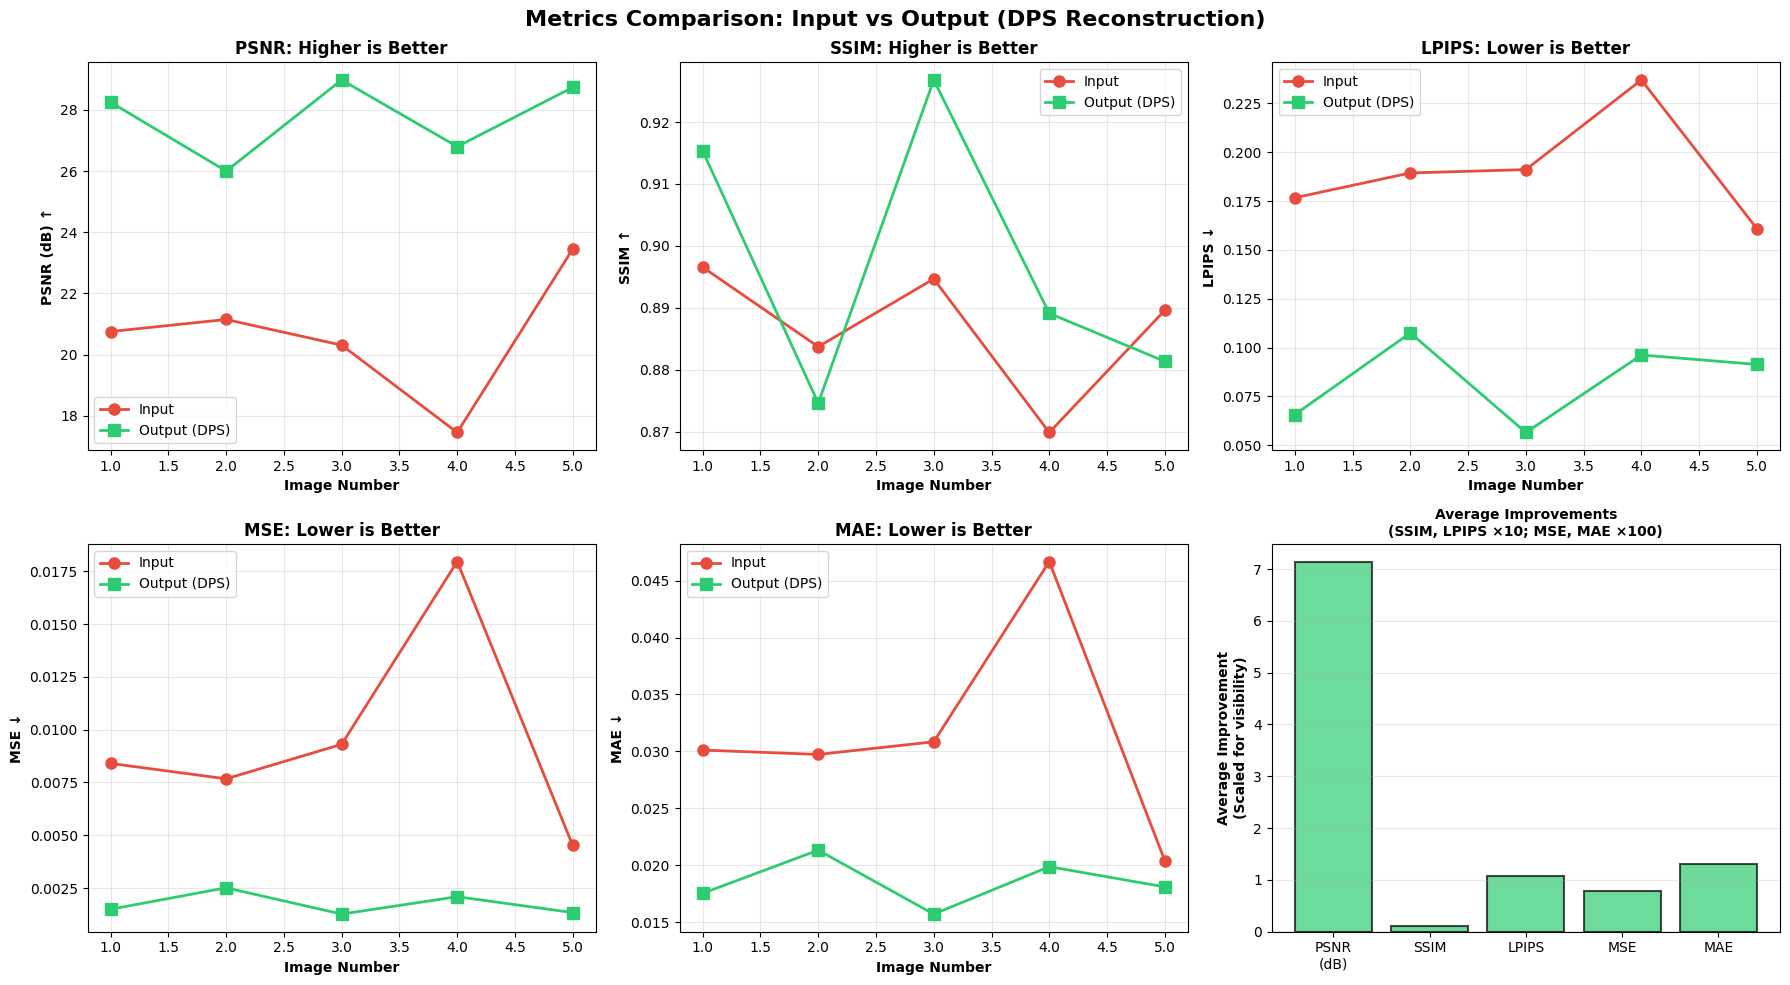

✓ Metrics visualization saved to 'metrics_comparison.png'


In [19]:
# Create visualizations of metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Metrics Comparison: Input vs Output (DPS Reconstruction)', fontsize=16, fontweight='bold')

image_indices = list(range(1, len(comprehensive_metrics) + 1))

# PSNR
axes[0, 0].plot(image_indices, [m['input_psnr'] for m in comprehensive_metrics],
                'o-', label='Input', linewidth=2, markersize=8, color='#e74c3c')
axes[0, 0].plot(image_indices, [m['output_psnr'] for m in comprehensive_metrics],
                's-', label='Output (DPS)', linewidth=2, markersize=8, color='#2ecc71')
axes[0, 0].set_xlabel('Image Number', fontweight='bold')
axes[0, 0].set_ylabel('PSNR (dB) ↑', fontweight='bold')
axes[0, 0].set_title('PSNR: Higher is Better', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# SSIM
axes[0, 1].plot(image_indices, [m['input_ssim'] for m in comprehensive_metrics],
                'o-', label='Input', linewidth=2, markersize=8, color='#e74c3c')
axes[0, 1].plot(image_indices, [m['output_ssim'] for m in comprehensive_metrics],
                's-', label='Output (DPS)', linewidth=2, markersize=8, color='#2ecc71')
axes[0, 1].set_xlabel('Image Number', fontweight='bold')
axes[0, 1].set_ylabel('SSIM ↑', fontweight='bold')
axes[0, 1].set_title('SSIM: Higher is Better', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# LPIPS
axes[0, 2].plot(image_indices, [m['input_lpips'] for m in comprehensive_metrics],
                'o-', label='Input', linewidth=2, markersize=8, color='#e74c3c')
axes[0, 2].plot(image_indices, [m['output_lpips'] for m in comprehensive_metrics],
                's-', label='Output (DPS)', linewidth=2, markersize=8, color='#2ecc71')
axes[0, 2].set_xlabel('Image Number', fontweight='bold')
axes[0, 2].set_ylabel('LPIPS ↓', fontweight='bold')
axes[0, 2].set_title('LPIPS: Lower is Better', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# MSE
axes[1, 0].plot(image_indices, [m['input_mse'] for m in comprehensive_metrics],
                'o-', label='Input', linewidth=2, markersize=8, color='#e74c3c')
axes[1, 0].plot(image_indices, [m['output_mse'] for m in comprehensive_metrics],
                's-', label='Output (DPS)', linewidth=2, markersize=8, color='#2ecc71')
axes[1, 0].set_xlabel('Image Number', fontweight='bold')
axes[1, 0].set_ylabel('MSE ↓', fontweight='bold')
axes[1, 0].set_title('MSE: Lower is Better', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MAE
axes[1, 1].plot(image_indices, [m['input_mae'] for m in comprehensive_metrics],
                'o-', label='Input', linewidth=2, markersize=8, color='#e74c3c')
axes[1, 1].plot(image_indices, [m['output_mae'] for m in comprehensive_metrics],
                's-', label='Output (DPS)', linewidth=2, markersize=8, color='#2ecc71')
axes[1, 1].set_xlabel('Image Number', fontweight='bold')
axes[1, 1].set_ylabel('MAE ↓', fontweight='bold')
axes[1, 1].set_title('MAE: Lower is Better', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Improvement bar chart
metrics_names = ['PSNR\n(dB)', 'SSIM', 'LPIPS', 'MSE', 'MAE']
improvements = [
    avg_metrics['psnr_improvement'],
    avg_metrics['ssim_improvement'] * 10,  # Scale for visibility
    avg_metrics['lpips_improvement'] * 10,  # Scale for visibility
    avg_metrics['mse_improvement'] * 100,  # Scale for visibility
    avg_metrics['mae_improvement'] * 100   # Scale for visibility
]
colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvements]

axes[1, 2].bar(metrics_names, improvements, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 2].set_ylabel('Average Improvement\n(Scaled for visibility)', fontweight='bold')
axes[1, 2].set_title('Average Improvements\n(SSIM, LPIPS ×10; MSE, MAE ×100)', fontweight='bold', fontsize=10)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Metrics visualization saved to 'metrics_comparison.png'")

## 15. Export Metrics to CSV

Save all metrics to a CSV file for further analysis or reporting.

In [20]:
# Export comprehensive metrics to CSV
csv_data = []

for idx, metrics in enumerate(comprehensive_metrics, 1):
    csv_data.append({
        'Image_Number': idx,
        'Image_Name': metrics['name'],

        # Input metrics
        'Input_PSNR_dB': metrics['input_psnr'],
        'Input_SSIM': metrics['input_ssim'],
        'Input_LPIPS': metrics['input_lpips'],
        'Input_MSE': metrics['input_mse'],
        'Input_MAE': metrics['input_mae'],

        # Output metrics
        'Output_PSNR_dB': metrics['output_psnr'],
        'Output_SSIM': metrics['output_ssim'],
        'Output_LPIPS': metrics['output_lpips'],
        'Output_MSE': metrics['output_mse'],
        'Output_MAE': metrics['output_mae'],

        # Improvements
        'Improvement_PSNR_dB': metrics['psnr_improvement'],
        'Improvement_SSIM': metrics['ssim_improvement'],
        'Improvement_LPIPS': metrics['lpips_improvement'],
        'Improvement_MSE': metrics['mse_improvement'],
        'Improvement_MAE': metrics['mae_improvement'],
    })

# Add average row
csv_data.append({
    'Image_Number': 'AVERAGE',
    'Image_Name': 'All Images',

    'Input_PSNR_dB': avg_metrics['input_psnr'],
    'Input_SSIM': avg_metrics['input_ssim'],
    'Input_LPIPS': avg_metrics['input_lpips'],
    'Input_MSE': avg_metrics['input_mse'],
    'Input_MAE': avg_metrics['input_mae'],

    'Output_PSNR_dB': avg_metrics['output_psnr'],
    'Output_SSIM': avg_metrics['output_ssim'],
    'Output_LPIPS': avg_metrics['output_lpips'],
    'Output_MSE': avg_metrics['output_mse'],
    'Output_MAE': avg_metrics['output_mae'],

    'Improvement_PSNR_dB': avg_metrics['psnr_improvement'],
    'Improvement_SSIM': avg_metrics['ssim_improvement'],
    'Improvement_LPIPS': avg_metrics['lpips_improvement'],
    'Improvement_MSE': avg_metrics['mse_improvement'],
    'Improvement_MAE': avg_metrics['mae_improvement'],
})

# Create DataFrame and save to CSV
df_export = pd.DataFrame(csv_data)
csv_filename = 'dps_comprehensive_metrics.csv'
df_export.to_csv(csv_filename, index=False, float_format='%.6f')

print("="*70)
print(f"✓ Metrics exported to: {csv_filename}")
print("="*70)
print(f"\nFile contains:")
print(f"  - {len(comprehensive_metrics)} image entries")
print(f"  - 1 average summary row")
print(f"  - {len(df_export.columns)} columns total")
print(f"\nColumns:")
for col in df_export.columns:
    print(f"  - {col}")
print("\n" + "="*70)

✓ Metrics exported to: dps_comprehensive_metrics.csv

File contains:
  - 5 image entries
  - 1 average summary row
  - 17 columns total

Columns:
  - Image_Number
  - Image_Name
  - Input_PSNR_dB
  - Input_SSIM
  - Input_LPIPS
  - Input_MSE
  - Input_MAE
  - Output_PSNR_dB
  - Output_SSIM
  - Output_LPIPS
  - Output_MSE
  - Output_MAE
  - Improvement_PSNR_dB
  - Improvement_SSIM
  - Improvement_LPIPS
  - Improvement_MSE
  - Improvement_MAE



## 16. Metrics Interpretation Guide

### Understanding the Metrics:

#### 📊 **PSNR (Peak Signal-to-Noise Ratio)** ↑ Higher is Better
- **Range**: Typically 20-50 dB (higher is better)
- **Meaning**: Measures pixel-level accuracy
- **Interpretation**:
  - < 20 dB: Poor quality
  - 20-25 dB: Fair quality
  - 25-30 dB: Good quality
  - 30-40 dB: Very good quality
  - \> 40 dB: Excellent quality
- **Note**: PSNR doesn't always correlate with perceptual quality

#### 🏗️ **SSIM (Structural Similarity Index)** ↑ Higher is Better
- **Range**: 0 to 1 (1 = identical images)
- **Meaning**: Measures structural similarity and perceived quality
- **Interpretation**:
  - < 0.50: Poor structural similarity
  - 0.50-0.70: Fair similarity
  - 0.70-0.85: Good similarity
  - 0.85-0.95: Very good similarity
  - \> 0.95: Excellent similarity
- **Note**: Better correlates with human perception than PSNR

#### 👁️ **LPIPS (Learned Perceptual Image Patch Similarity)** ↓ Lower is Better
- **Range**: 0 to 1+ (0 = identical images)
- **Meaning**: Deep learning-based perceptual distance
- **Interpretation**:
  - < 0.05: Perceptually very similar
  - 0.05-0.10: Similar
  - 0.10-0.20: Moderate difference
  - 0.20-0.40: Large difference
  - \> 0.40: Very different
- **Note**: Best correlates with human perceptual judgments

#### 🎯 **MSE (Mean Squared Error)** ↓ Lower is Better
- **Range**: 0 to 1 (for normalized images)
- **Meaning**: Average squared pixel-level error
- **Interpretation**:
  - < 0.001: Excellent
  - 0.001-0.01: Good
  - 0.01-0.05: Fair
  - \> 0.05: Poor
- **Note**: Sensitive to outliers

#### 📏 **MAE (Mean Absolute Error)** ↓ Lower is Better
- **Range**: 0 to 1 (for normalized images)
- **Meaning**: Average absolute pixel-level error
- **Interpretation**:
  - < 0.01: Excellent
  - 0.01-0.05: Good
  - 0.05-0.10: Fair
  - \> 0.10: Poor
- **Note**: More robust to outliers than MSE

---

### 🎓 **Recommendations:**

1. **For overall quality assessment**: Focus on **PSNR** and **SSIM**
2. **For perceptual quality**: Prioritize **LPIPS** and **SSIM**
3. **For pixel-accurate reconstruction**: Check **MSE** and **MAE**
4. **For human perception**: **LPIPS** > **SSIM** > **PSNR**

### ✅ **Good Performance Indicators:**
- PSNR improvement > 5 dB
- SSIM improvement > 0.1
- LPIPS improvement > 0.05 (remember: lower LPIPS is better)
- Consistent improvements across all metrics

In [21]:
# Create output directory
os.makedirs('results', exist_ok=True)

# Save results for all images
for idx, result in enumerate(reconstructed_images):
    img_num = str(idx + 1).zfill(3)  # 001, 002, 003, etc.

    # Save individual images
    plt.imsave(f'results/image_{img_num}_original.png', clear_color(result['original']))
    plt.imsave(f'results/image_{img_num}_degraded.png', clear_color(result['degraded']))
    plt.imsave(f'results/image_{img_num}_reconstructed.png', clear_color(result['reconstructed']))

    print(f"✓ Saved results for image {idx+1} ({result['name']}):")
    print(f"  - results/image_{img_num}_original.png")
    print(f"  - results/image_{img_num}_degraded.png")
    print(f"  - results/image_{img_num}_reconstructed.png")

# Also save a combined comparison image for each
for idx, result in enumerate(reconstructed_images):
    img_num = str(idx + 1).zfill(3)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(clear_color(result['original']))
    axes[0].set_title('Original', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(clear_color(result['degraded']))
    axes[1].set_title('Degraded', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(clear_color(result['reconstructed']))
    axes[2].set_title('DPS Reconstruction', fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(f'results/image_{img_num}_comparison.png', dpi=200, bbox_inches='tight')
    plt.close()

print(f"\n{'='*70}")
print(f"✓ All results saved successfully!")
print(f"{'='*70}")
print(f"Total images processed: {len(reconstructed_images)}")
print(f"Files saved in: ./results/")
print(f"\nYou can download these files from the Files panel on the left.")
print(f"{'='*70}")


✓ Saved results for image 1 (19857.jpg):
  - results/image_001_original.png
  - results/image_001_degraded.png
  - results/image_001_reconstructed.png
✓ Saved results for image 2 (26678.jpg):
  - results/image_002_original.png
  - results/image_002_degraded.png
  - results/image_002_reconstructed.png
✓ Saved results for image 3 (13734.jpg):
  - results/image_003_original.png
  - results/image_003_degraded.png
  - results/image_003_reconstructed.png
✓ Saved results for image 4 (23566.jpg):
  - results/image_004_original.png
  - results/image_004_degraded.png
  - results/image_004_reconstructed.png
✓ Saved results for image 5 (01342.jpg):
  - results/image_005_original.png
  - results/image_005_degraded.png
  - results/image_005_reconstructed.png

✓ All results saved successfully!
Total images processed: 5
Files saved in: ./results/

You can download these files from the Files panel on the left.


## 17. Download Results (Optional)


In [22]:
# Uncomment to download results to your local machine
# from google.colab import files
# files.download('dps_results.png')
# files.download('results/reconstructed.png')


## 18. Try Different Tasks 🔄

You can modify the task configuration to solve different inverse problems. Here are some examples:

### Example 1: Gaussian Deblurring
```python
task_config = {
    'conditioning': {'method': 'ps', 'params': {'scale': 0.3}},
    'measurement': {
        'operator': {
            'name': 'gaussian_blur',
            'kernel_size': 61,
            'intensity': 3.0
        },
        'noise': {'name': 'gaussian', 'sigma': 0.05}
    }
}
```

### Example 2: Inpainting - Box Mask (Center Region)

**⚠️ Important:** For box masks, ensure: `margin + mask_size + margin < 256`

**Option A: Large mask (128×128) with small margin**
```python
task_config = {
    'conditioning': {'method': 'ps', 'params': {'scale': 0.5}},
    'measurement': {
        'operator': {'name': 'inpainting'},
        'noise': {'name': 'gaussian', 'sigma': 0.0},
        'mask_opt': {
            'mask_type': 'box',
            'mask_len_range': (128, 129),  # 128×128 mask
            'image_size': 256,
            'margin': (16, 16)  # Small margin for random placement
        }
    }
}
```

**Option B: Medium mask (96×96) with medium margin**
```python
task_config = {
    'conditioning': {'method': 'ps', 'params': {'scale': 0.5}},
    'measurement': {
        'operator': {'name': 'inpainting'},
        'noise': {'name': 'gaussian', 'sigma': 0.0},
        'mask_opt': {
            'mask_type': 'box',
            'mask_len_range': (96, 97),  # 96×96 mask
            'image_size': 256,
            'margin': 32  # Can use int (converts to tuple)
        }
    }
}
```

**Option C: Small mask (64×64) with large margin (more centered)**
```python
task_config = {
    'conditioning': {'method': 'ps', 'params': {'scale': 0.5}},
    'measurement': {
        'operator': {'name': 'inpainting'},
        'noise': {'name': 'gaussian', 'sigma': 0.0},
        'mask_opt': {
            'mask_type': 'box',
            'mask_len_range': (64, 65),  # 64×64 mask
            'image_size': 256,
            'margin': (64, 64)  # Large margin = more centered
        }
    }
}
```

### Example 2b: Inpainting - Random Mask (Scattered Pixels)
```python
task_config = {
    'conditioning': {'method': 'ps+', 'params': {'scale': 0.5, 'num_sampling': 5}},
    'measurement': {
        'operator': {'name': 'inpainting'},
        'noise': {'name': 'gaussian', 'sigma': 0.0},
        'mask_opt': {
            'mask_type': 'random',
            'mask_prob_range': (0.3, 0.7),  # 30-70% pixels masked
            'image_size': 256
        }
    }
}
```

### Example 3: Motion Deblurring
```python
task_config = {
    'conditioning': {'method': 'ps', 'params': {'scale': 0.3}},
    'measurement': {
        'operator': {
            'name': 'motion_blur',
            'kernel_size': 61,
            'intensity': 0.5  # Motion blur intensity (0.1 to 1.0, higher = more blur)
        },
        'noise': {'name': 'gaussian', 'sigma': 0.05}
    }
}
```

**To try a different task:**
1. Copy one of the configurations above
2. Replace the `task_config` in Section 4
3. Re-run from Section 5 onwards

**Note for Inpainting:**
- `mask_len_range`: (min, max) size of the box in pixels
- `mask_prob_range`: (min, max) probability of pixels to mask (for random)


## 19. Summary

This notebook demonstrates **Diffusion Posterior Sampling (DPS)** for solving inverse problems:

✅ **What we did:**
- Loaded a pre-trained diffusion model (256×256 FFHQ)
- Created a degraded measurement (e.g., low-resolution + noise)
- Used DPS to reconstruct the original high-quality image
- Evaluated the reconstruction quality

✅ **Key advantages of DPS:**
- Works with **any** forward operator (super-resolution, deblurring, inpainting, etc.)
- Handles **noisy** measurements
- No task-specific training required
- State-of-the-art results on various inverse problems

✅ **Performance:**
- On GPU (T4): ~5-10 minutes for 1000 steps
- On GPU (V100/A100): ~2-5 minutes for 1000 steps
- Can be sped up using fewer timesteps (e.g., 250 steps)


## 20. Download Results to Google Drive

Save all results and metrics CSV file to your Google Drive for use in your GitHub repository README.


In [ ]:
from google.colab import files
import shutil
import os

print("="*70)
print("DOWNLOADING RESULTS TO GOOGLE DRIVE")
print("="*70)

# Create a folder in Google Drive for the results
drive_output_dir = '/content/drive/MyDrive/DPS_Results'
os.makedirs(drive_output_dir, exist_ok=True)
print(f"✓ Created directory: {drive_output_dir}")

# Copy all results images to Drive
print("\n📁 Copying result images...")
results_dir = 'results'
if os.path.exists(results_dir):
    for filename in os.listdir(results_dir):
        src = os.path.join(results_dir, filename)
        dst = os.path.join(drive_output_dir, filename)
        shutil.copy2(src, dst)
        print(f"  ✓ Copied: {filename}")
else:
    print(f"  ⚠ Results directory not found at {results_dir}")

# Copy metrics CSV file to Drive
print("\n📊 Copying metrics CSV file...")
csv_file = 'dps_comprehensive_metrics.csv'
if os.path.exists(csv_file):
    dst_csv = os.path.join(drive_output_dir, csv_file)
    shutil.copy2(csv_file, dst_csv)
    print(f"  ✓ Copied: {csv_file}")
else:
    print(f"  ⚠ CSV file not found at {csv_file}")

# Copy the metrics visualization
print("\n📈 Copying metrics visualization...")
metrics_viz = 'metrics_comparison.png'
if os.path.exists(metrics_viz):
    dst_viz = os.path.join(drive_output_dir, metrics_viz)
    shutil.copy2(metrics_viz, dst_viz)
    print(f"  ✓ Copied: {metrics_viz}")
else:
    print(f"  ⚠ Metrics visualization not found at {metrics_viz}")

# Copy the combined results visualization
print("\n🎨 Copying combined results visualization...")
results_viz = 'dps_all_results.png'
if os.path.exists(results_viz):
    dst_all_results = os.path.join(drive_output_dir, results_viz)
    shutil.copy2(results_viz, dst_all_results)
    print(f"  ✓ Copied: {results_viz}")
else:
    print(f"  ⚠ Combined results visualization not found at {results_viz}")

print(f"\n{'='*70}")
print("✅ ALL FILES DOWNLOADED TO GOOGLE DRIVE!")
print(f"{'='*70}")
print(f"\n📂 Location: {drive_output_dir}")
print(f"\n📋 Files available for download:")
print(f"  - dps_all_results.png (All 3 reconstructed images comparison)")
print(f"  - metrics_comparison.png (6-plot metrics visualization)")
print(f"  - dps_comprehensive_metrics.csv (Complete metrics table)")
print(f"  - image_XXX_original.png (Individual original images)")
print(f"  - image_XXX_degraded.png (Individual degraded images)")
print(f"  - image_XXX_reconstructed.png (Individual reconstructed images)")
print(f"  - image_XXX_comparison.png (Individual side-by-side comparisons)")
print(f"\n💡 Next steps:")
print(f"  1. Open Google Drive and navigate to {drive_output_dir}")
print(f"  2. Download the files you need for your GitHub README")
print(f"  3. Use the images and metrics in your documentation")
print(f"\n🎯 Recommended for README:")
print(f"  - Use 'dps_all_results.png' as the main results visualization")
print(f"  - Use 'metrics_comparison.png' to show quantitative results")
print(f"  - Use 'dps_comprehensive_metrics.csv' for detailed metrics table")
print(f"{'='*70}")
